# Scratch Notebook

In [66]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", True)
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import optax
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning
import models

from jax.experimental import optimizers

key = random.PRNGKey(0)
key, subkey = random.split(key)

from jax.scipy.stats import norm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
%autoreload

# test kernel modules

In [88]:
sizes=[4, 4, 3]

In [112]:
d = 2
key, subkey = random.split(key)
x_dummy = random.normal(subkey, shape=(2,d))

key, subkey = random.split(key)
k = hk.transform(lambda x: nets.RBFKernel(parametrization="full")(x))
params = k.init(subkey, x_dummy)

key, subkey = random.split(key)
k2 = hk.transform(lambda x: nets.RBFKernel(scale_param=True)(x))
params2 = k2.init(subkey, x_dummy)

In [113]:
key, subkey = random.split(key)
xy = random.normal(subkey, shape=(2,d))
xy

DeviceArray([[-1.6102057 ,  0.17245354],
             [ 2.118151  ,  1.1614186 ]], dtype=float32)

In [114]:
kernel = kernels.get_rbf_kernel(1)
kernel(*xy)

DeviceArray(0.00058767, dtype=float32)

In [115]:
k.apply(params, None, xy)

DeviceArray(0.00058767, dtype=float32)

In [116]:
params2

frozendict({
  'rbf_kernel': frozendict({
                  'bandwidth': DeviceArray([1., 1.], dtype=float32),
                  'scale': DeviceArray(1., dtype=float32),
                }),
})

In [117]:
k2.apply(params2, None, xy)

DeviceArray(0.00058767, dtype=float32)

## play with params

In [118]:
d = hk.data_structures.to_mutable_dict(params2)
d["rbf_kernel"]["scale"] = np.array(2.)

In [119]:
k2.apply(d, None, xy) == 2* k2.apply(params2, None, xy)

DeviceArray(True, dtype=bool)

In [131]:
d = hk.data_structures.to_mutable_dict(params2)
d["rbf_kernel"]["bandwidth"] = np.array([2., 2.])

In [132]:
k2.apply(d, None, xy)# == 2* k2.apply(params2, None, xy)

DeviceArray(0.9815735, dtype=float32)

# ARD kernel

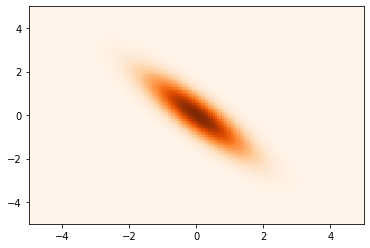

In [115]:
key, subkey = random.split(key)
sigma = random.normal(key, shape=(2,2))
ard = kernels.get_ard_kernel(sigma, dim=2)

ard_f = lambda x: ard(x, [0.,0.])

plot.plot_fun_2d(ard_f)

# classes and inheritance


In [22]:
class FooMixin:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)  # forwards all unused arguments
        self.foo = 'foo'

class Bar:
    def __init__(self, bar):
        self.bar = bar

class FooBar(FooMixin, Bar):
    def __init__(self, bar='bar'):
        super().__init__(bar)  # a single call is enough to invoke
                               # all parent constructors

In [23]:
fb = FooBar('testbar')

In [30]:
class A:
    def __init__(self):
#         super().__init__()
        print("init A")

class B:
    def __init__(self):
        super().__init__()
        print("init B")

class C(A, B):
    def __init__(self):
        super().__init__()

c = C()

init A


# testing vec

In [11]:
def vec_fn(x):
    vec = nets.VectorField([4,4,1])
    return vec(x)
v = hk.transform(vec_fn)

In [12]:
x = np.ones((1,))
params = v.init(key, x)

In [13]:
x = random.normal(key, (10,1))
out = v.apply(params, None, x)
out

DeviceArray([[ 0.05139753],
             [ 0.02016285],
             [ 0.85884106],
             [-0.03981328],
             [ 0.2630499 ],
             [ 0.82992554],
             [ 0.30326903],
             [ 0.01443263],
             [ 0.12501118],
             [ 0.14325386]], dtype=float32)

In [ ]:
sdlfj

# Normalizing Layer

In [ ]:
class Norm(hk.Module):
    """Much simpler than using BatchNorm"""
    def __init__(self, name=None):
        super().__init__(name=name)

    def __call__(self, x):
        """x is a batch of particles of shape (n, d)"""
        mean = np.mean(x, axis=0)
        std = np.std(x, axis=0)
        return (x - mean) / (std + 1e-5)

def test_fn(x):
    norm = Norm()
    return norm(x)

t = hk.transform(test_fn)

In [ ]:
x = random.normal(key, (5000,)) * 2 + 3
out = t.apply(None, None, x)

In [ ]:
plt.hist(out, density=True, alpha=0.5, bins=30, label="Normalized")
_ = plt.hist(x, density=True, alpha=0.5, bins=30, label="Original")
plt.legend()

# test haiku batching

* hk.Module itself does not know about batch dimensions. It just calls whatever method you implement directly on the input of apply.
* However, many layers do care about batch dimensions. E.g. `hk.Linear` is made for vector inputs; all other dims are treated as batch dimensions (see also the tutorial Linear implementation on the haiku github readme).
* `BatchNorm` normalizes across all dimensions except the *last* (since we don't wanna normalize across a single input). So all dimensions other than the last are treated as batch dimensions.
* Upshot: if I want to add a layer that operates on the whole batch in a non-entry-wise manner, I can just do that by writing a `hk.Layer` that uses the batch dim.

In [29]:
class Test(hk.Module):
    def __init__(self):
        super().__init__()

    def __call__(self, x):
        a = hk.get_parameter()
        return x * a

def t_fn(x):
    norm = hk.BatchNorm(False, False, 0)
    return norm(x, is_training=True)

t = hk.transform_with_state(t_fn)

In [30]:
key, subkey = random.split(key)
x_dummy = random.normal(subkey, shape=(2,))
params, state = t.init(key, x_dummy)

In [31]:
t.apply(params, state, key, x_dummy)

(DeviceArray([0., 0.], dtype=float32),
 frozendict({
   'batch_norm/~/mean_ema': frozendict({
                              'average': DeviceArray([ 0.00870693, -0.04888531], dtype=float32),
                              'counter': DeviceArray(1, dtype=int32),
                              'hidden': DeviceArray([ 0.00870693, -0.04888531], dtype=float32),
                            }),
   'batch_norm/~/var_ema': frozendict({
                             'average': DeviceArray([0., 0.], dtype=float32),
                             'counter': DeviceArray(1, dtype=int32),
                             'hidden': DeviceArray([0., 0.], dtype=float32),
                           }),
 }))

In [32]:
x = random.normal(subkey, shape=(1000,2))
out, state = t.apply(params, state, key, x)
out - x

DeviceArray([[ 0.00034833,  0.00524759],
             [-0.00066996, -0.00426349],
             [-0.01071846, -0.00202864],
             ...,
             [ 0.00852859, -0.00840089],
             [ 0.00702465, -0.0185225 ],
             [ 0.00656211, -0.00908336]], dtype=float32)

In [33]:
state

frozendict({
  'batch_norm/~/mean_ema': frozendict({
                             'average': DeviceArray([[-0.01274119,  0.0064392 ]], dtype=float32),
                             'counter': DeviceArray(1, dtype=int32),
                             'hidden': DeviceArray([[-0.01274119,  0.0064392 ]], dtype=float32),
                           }),
  'batch_norm/~/var_ema': frozendict({
                            'average': DeviceArray([[0.9760262 , 0.98491955]], dtype=float32),
                            'counter': DeviceArray(1, dtype=int32),
                            'hidden': DeviceArray([[0.9760262 , 0.98491955]], dtype=float32),
                          }),
})

# comparing SGLD

In [ ]:
target = distributions.Gaussian(0, 1)
proposal = distributions.Gaussian(-3, 1)

key, subkey = random.split(key)
gradient = models.EnergyGradient(target, subkey)
key, subkey = random.split(key)
particles = models.Particles(subkey, gradient.gradient, proposal, n_particles=50, num_groups=1, learning_rate=1e-1, optimizer="adam", noise_level=1.)

In [ ]:
scales = []
for _ in range(100):
    particles.step(None)
    scales.append(onp.squeeze(onp.abs(particles.noise_scales)).tolist())

In [ ]:
fig, axs = plt.subplots(2, figsize=[8, 6])
particles.plot_trajectories(marker=".", ax=axs[0])
axs[1].plot(scales, "--.")
plt.yscale("log")

In [ ]:
fig, axs = plt.subplots(2, figsize=[8, 6])
particles.plot_trajectories(marker=".", ax=axs[0])
axs[1].plot(scales, "--.")
plt.yscale("log")

# dists

In [ ]:
from distributions import Gaussian as G

In [ ]:
%autoreload

In [ ]:
target = G(0,1)

In [ ]:
learner = models.SDLearner(target)
particles = models.Particles(key, learner.gradient, target)

In [ ]:
learner.train(particles.next_batch, key=subkey, n_steps=5)
particles.step(learner.get_params())

In [ ]:
learner.rundata["train_steps"]

In [ ]:
learner.step_counter

In [ ]:
learner.rundata["step_counter"]

# check if dists have correct statistics

In [ ]:
%autoreload

In [ ]:
def check_dist(dist, key):
    s = dist.sample(10**4, key=key)
    errs = {
        "se_mean": np.sum((np.mean(s, axis=0) - dist.mean)**2),
        "se_cov": np.sum((np.cov(s, rowvar=False) - dist.cov)**2),
    }
    for k, err in errs.items():
        if err > 1e-2:
            print(f"{k} to big! {k} = {err} > 0.01")
    return

In [ ]:
dist = distributions.Gaussian(0, 1)
check_dist(dist, key)

In [ ]:
dist, _ = distributions.funnel.get()
check_dist(dist, key) # fine, just hard to approximate

In [ ]:
dist, _ = distributions.banana_target.get()
check_dist(dist, key) # fine

In [ ]:
dist, _ = distributions.ring_target.get()
check_dist(dist, key) # fine

In [ ]:
dist, _ = distributions.squiggle_target.get()
check_dist(dist, key)